In [12]:
import numpy as np
import os
import pandas as pd
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
from tqdm import tqdm
from keras.preprocessing import image
from PIL import Image
from keras.applications import inception_v3
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline               

labels=pd.read_csv('labels.csv')
target=labels.set_index('id')
target=target.to_dict()['breed']

In [33]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# define function to load train, test, and validation datasets
def load_dataset(path):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

In [18]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [34]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset('train_val_test/train')
val_files, val_targets = load_dataset('train_val_test/val')
test_files, test_targets = load_dataset('train_val_test/test')

# load list of dog breed names
breeds = [item[21:-1] for item in sorted(glob("train_val_test/train/*/"))]

In [35]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [37]:
input_size=224
num_classes=120
S=1
train_len=len(train_files)

inception_bottleneck=inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')
train_i_bf = inception_bottleneck.predict(train_tensors, batch_size=32, verbose=1)
val_i_bf = inception_bottleneck.predict(val_tensors, batch_size=32, verbose=1)
test_i_bf = inception_bottleneck.predict(test_tensors, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(val_i_bf.shape, val_i_bf.size))
print('InceptionV3 test bottleneck features shape: {} size: {:,}'.format(test_i_bf.shape, test_i_bf.size))

1022/1022 [==============================] - 161s 157ms/step
InceptionV3 train bottleneck features shape: (8185, 2048) size: 16,762,880
InceptionV3 valid bottleneck features shape: (1015, 2048) size: 2,078,720
InceptionV3 test bottleneck features shape: (1022, 2048) size: 2,093,056


In [38]:
np.save('bottleneck_features_train_inception.npy', train_i_bf) 
np.save('bottleneck_features_val_inception.npy', val_i_bf) 
np.save('bottleneck_features_test_inception.npy', test_i_bf) 

In [43]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math

# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_inception.npy') 
val_data = np.load('bottleneck_features_val_inception.npy') 
test_data = np.load('bottleneck_features_test_inception.npy') 
batch_size=32
epochs=50

model = Sequential()  
#model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  
   
model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  
   
history = model.fit(train_data, train_targets,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(val_data, val_targets))  
   
model.save_weights('inception_model_2.h5')  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     val_data, val_targets, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

Train on 8185 samples, validate on 1015 samples
Epoch 1/50
8185/8185 [==============================] - 5s 623us/step - loss: 2.2907 - acc: 0.4762 - val_loss: 0.9231 - val_acc: 0.7409
Epoch 2/50
8185/8185 [==============================] - 3s 394us/step - loss: 1.1625 - acc: 0.6946 - val_loss: 0.8809 - val_acc: 0.7606
Epoch 3/50
8185/8185 [==============================] - 3s 398us/step - loss: 0.9988 - acc: 0.7300 - val_loss: 0.8997 - val_acc: 0.7557
Epoch 4/50
8185/8185 [==============================] - 3s 364us/step - loss: 0.8889 - acc: 0.7572 - val_loss: 0.8742 - val_acc: 0.7665
Epoch 5/50
8185/8185 [==============================] - 3s 354us/step - loss: 0.8416 - acc: 0.7709 - val_loss: 0.8432 - val_acc: 0.7744
Epoch 6/50
8185/8185 [==============================] - 3s 363us/step - loss: 0.7556 - acc: 0.7902 - val_loss: 0.9019 - val_acc: 0.7626
Epoch 7/50
8185/8185 [==============================] - 3s 390us/step - loss: 0.7416 - acc: 0.7978 - val_loss: 0.9621 - val_acc: 0.7773


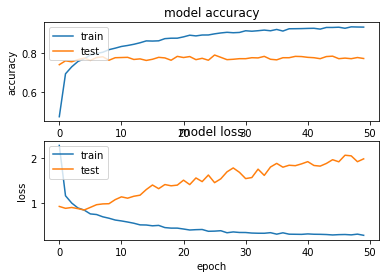

In [44]:
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

In [45]:
def report_accuracy(test_tensors, test_targets):
    # get index of predicted dog breed for each image in test set
    dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # Find out the Number of Samples
    num_test_samples = len(dog_breed_predictions)

    print("The Number of Test images are: {}".format(num_test_samples))

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)

In [48]:
model.load_weights('inception_model_2.h5')

print('For training set:')
report_accuracy(train_data, train_targets)

print('For validation set:')
report_accuracy(val_data, val_targets)

print('For test set:')
report_accuracy(test_data, test_targets)

For training set:
The Number of Test images are: 8185
Test accuracy: 99.1936%
For validation set:
The Number of Test images are: 1015
Test accuracy: 77.2414%
For test set:
The Number of Test images are: 1022
Test accuracy: 77.3973%
